In [6]:
using Pkg
Pkg.activate("..")

push!(LOAD_PATH, "../src")
using WriterVerifier

using Images, FileIO, Random, Plots, Statistics
Random.seed!(42);

  Activating project at `c:\Users\igorp\WriterVerifier`


In [7]:
image_folder = "../data/words"
writers = load_images(image_folder; max_per_writer=100);

Loaded 76 writers
f01: 100 images
d01: 100 images
g05: 100 images
e07: 100 images
e02: 100 images
a04: 100 images
p02: 100 images
p06: 100 images
r02: 100 images
h07: 100 images
b04: 100 images
k02: 100 images
d03: 100 images
d06: 100 images
c03: 100 images
b01: 100 images
c04: 100 images
f03: 100 images
c02: 100 images
g06: 100 images
l07: 100 images
j07: 100 images
k04: 100 images
e06: 100 images
l03: 100 images
a03: 100 images
r03: 100 images
n06: 100 images
j04: 100 images
r06: 100 images
n02: 100 images
g03: 100 images
k01: 86 images
j06: 100 images
h04: 100 images
m02: 100 images
b05: 100 images
g02: 100 images
k03: 100 images
c01: 100 images
f02: 100 images
p03: 100 images
p01: 100 images
a05: 100 images
d05: 100 images
m01: 100 images
g04: 100 images
h06: 100 images
f04: 100 images
n01: 100 images
j01: 100 images
b02: 100 images
b03: 100 images
l04: 100 images
b06: 100 images
n04: 100 images
e01: 100 images
l01: 100 images
a02: 100 images
a01: 100 images
h02: 100 images
a06: 10

In [8]:
println("Dataset statistics:")
println("Total writers: $(length(writers))")
println("Total images: $(sum(length(images) for images in values(writers)))")

image_counts = [length(images) for images in values(writers)]
println("\nImages per writer:")
println("Min: $(minimum(image_counts))")
println("Max: $(maximum(image_counts))")
println("Mean: $(round(sum(image_counts)/length(image_counts), digits=1))")
println("Median: $(round(median(image_counts), digits=1))")

Dataset statistics:
Total writers: 76
Total images: 7560

Images per writer:
Min: 74
Max: 100
Mean: 99.5
Median: 100.0


In [9]:
writer_names = collect(keys(writers))
selected_writers = writer_names[1:min(5, length(writer_names))]

println("Sample writers:")
for writer in selected_writers
    println("$writer: $(length(writers[writer])) images")
    println("  First image: $(basename(writers[writer][1]))")
    println("  Last image: $(basename(writers[writer][end]))")
end

Sample writers:
f01: 100 images
  First image: f01-053-00-00.png
  Last image: f01-058-03-05.png
d01: 100 images
  First image: d01-016-00-00.png
  Last image: d01-019-03-05.png
g05: 100 images
  First image: g05-087-00-00.png
  Last image: g05-094-04-05.png
e07: 100 images
  First image: e07-000-00-00.png
  Last image: e07-003-04-05.png
e02: 100 images
  First image: e02-000-00-00.png
  Last image: e02-014-03-05.png


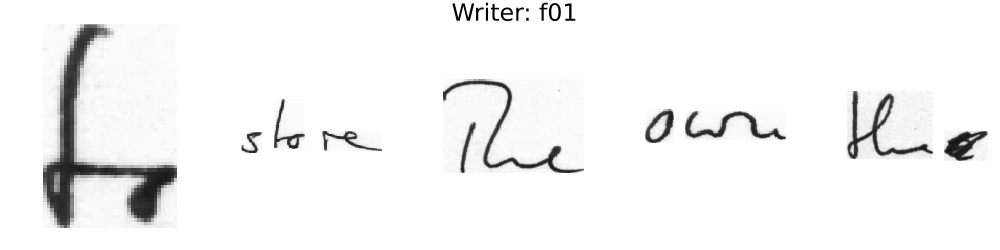

In [19]:
function display_writer_samples(writer_id, n_samples=5)
    if !haskey(writers, writer_id)
        println("Writer $writer_id not found")
        return
    end
    
    images = writers[writer_id]
    n_show = min(n_samples, length(images))
    sample_indices = randperm(length(images))[1:n_show]
    
    plots = []
    for i in sample_indices
        img_path = images[i]
        img = load(img_path)
        
        p = plot(Gray.(img), 
                axis=false,
                showaxis=false,
                grid=false)
        push!(plots, p)
    end
    
    plot(plots..., layout=(1, n_show), size=(200*n_show, 250),
         plot_title="Writer: $writer_id")
end

display_writer_samples(first(writer_names))

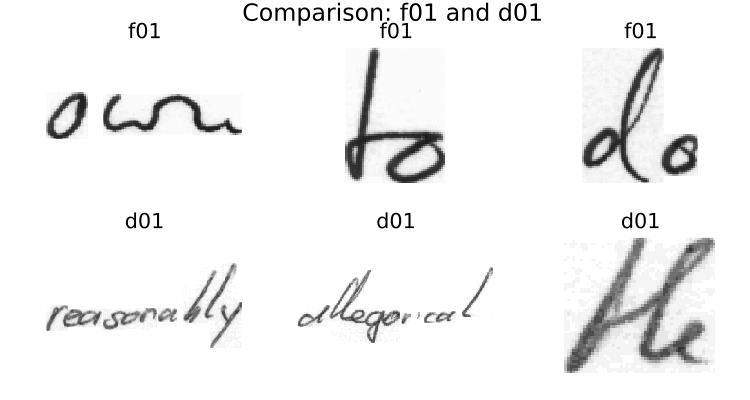

In [25]:
function compare_writers(writer1, writer2, n_samples=3)
    plots = []
    
    for (i, writer) in enumerate([writer1, writer2])
        if !haskey(writers, writer)
            println("Writer $writer not found")
            continue
        end
        
        images = writers[writer]
        sample_indices = randperm(length(images))[1:min(n_samples, length(images))]
        
        for j in sample_indices
            img_path = images[j]
            img = load(img_path)
            
            p = plot(Gray.(img),
                    title="$writer",
                    axis=false,
                    showaxis=false,
                    grid=false)
            push!(plots, p)
        end
    end
    
    plot(plots..., layout=(2, n_samples), size=(250*n_samples, 400),
         plot_title="Comparison: $writer1 and $writer2")
end

if length(writer_names) >= 2
    compare_writers(writer_names[1], writer_names[2])
end

Testing image processing on: f01-053-00-00.png
Original size: (90, 136)
Processed size: (64, 64, 1)
Processed type: Float32
Processed range: [-0.765, 0.969]


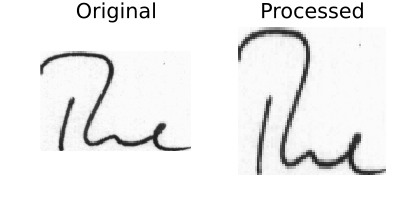

In [ ]:
test_image_path = writers[first(writer_names)][1]
println("Testing image processing on: $(basename(test_image_path))")

original_img = load(test_image_path)
processed_img = process_image(test_image_path)

println("Original size: $(size(original_img))")
println("Processed size: $(size(processed_img))")
println("Processed type: $(eltype(processed_img))")
println("Processed range: [$(round(minimum(processed_img), digits=3)), $(round(maximum(processed_img), digits=3))]")

p1 = plot(Gray.(original_img), title="Original", axis=false, showaxis=false, grid=false)
p2 = plot(Gray.((processed_img[:,:,1] .+ 1) ./ 2), title="Processed", axis=false, showaxis=false, grid=false)
plot(p1, p2, layout=(1,2), size=(400, 200))

In [13]:
pairs, labels = create_pairs(writers; positive=10, negative=10)

println("\nPair examples:")
for i in 1:min(5, length(pairs))
    path1, path2 = pairs[i]
    label = labels[i]
    
    writer1 = split(basename(path1), "-")[1]
    writer2 = split(basename(path2), "-")[1]
    
    label_text = label == 1 ? "SAME" : "DIFFERENT"
    println("$i. $writer1 vs $writer2 → $label_text")
end

Creating positive pairs...
Creating negative pairs...
Created 20 pairs
Positive: 10
Negative: 10

Pair examples:
1. l07 vs l07 → SAME
2. c02 vs c02 → SAME
3. j04 vs j04 → SAME
4. m04 vs m04 → SAME
5. f02 vs f02 → SAME


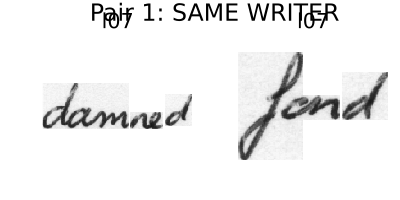

In [14]:
function visualize_pair(pair_idx)
    if pair_idx > length(pairs)
        println("Pair index out of range")
        return
    end
    
    path1, path2 = pairs[pair_idx]
    label = labels[pair_idx]
    
    img1 = load(path1)
    img2 = load(path2)
    
    writer1 = split(basename(path1), "-")[1]
    writer2 = split(basename(path2), "-")[1]
    
    label_text = label == 1 ? "SAME WRITER" : "DIFFERENT WRITERS"
    
    p1 = plot(Gray.(img1), title="$writer1", axis=false, showaxis=false, grid=false)
    p2 = plot(Gray.(img2), title="$writer2", axis=false, showaxis=false, grid=false)
    
    plot(p1, p2, layout=(1,2), size=(400, 200),
         plot_title="Pair $pair_idx: $label_text")
end

visualize_pair(1)